In this homework, you need to solve four tasks. The assignment should be uploaded in Jupyter Notebook format(`.ipynb`). Overall, there are 23 points, however, you can get a maximum of 20 points for this assignment( `your_points = max(your_points, 20)`). No bonus points will be transferred to the next assignment.

# Task 1. Non-parametric Density Estimation (6 points)

In [1]:
import numpy as np
import numpy.linalg as nla
import scipy
import scipy.stats
import pandas as pd

import pandas as pd
import numpy as np
import scipy.stats as sps

from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, cross_validate

from sklearn.neighbors import KernelDensity
from sklearn.metrics.pairwise import rbf_kernel

from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge

from statsmodels.nonparametric.kernel_regression import KernelReg
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Matplotlib settings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


# non-interactive
%matplotlib inline

#jupyterlab
# %matplotlib widget 

#jupyter-notebook
# %matplotlib notebook 

titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

matplotlib.rc('font', **{'family':'serif'})

You will work with data sampled from the mixture of Normal distributions:

In [3]:
seed1 = 31337
seed2 = 42
n_samples = 100

f1 = scipy.stats.norm(loc=0, scale=1)
f2 = scipy.stats.norm(loc=5, scale=1)
p1 = 0.3
p2 = 1 - p1

Xa = f1.rvs(size=int(p1 * n_samples), random_state=seed1)
Xb = f2.rvs(size=int(p2 * n_samples), random_state=seed2)
sample = np.concatenate([Xa, Xb])

a = -5
b = 10

x_values = np.linspace(a, b, 1000)
binedges = np.linspace(a, b, 10)
true_pdf = p1 * f1.pdf(x_values) + p2 * f2.pdf(x_values)

## Histogram estimate

$\newcommand{\boldX}{\boldsymbol{X}}$
$\newcommand{\xs}[1]{\boldX^{(#1)}}$
$\newcommand{\Sum}{\sum\limits}$
$\newcommand{\Int}{\int\limits}$
$\newcommand{\hatp}{\widehat{p}}$
$\newcommand{\hatJ}{\widehat{J}}$
$\newcommand{\lp}{\left(}$
$\newcommand{\rp}{\right)}$

Given a sample $\boldsymbol{X}^{(n)} = \boldsymbol{X}_1, \boldsymbol{X}_2, ..., \boldsymbol{X}_n \sim \; iid \; p(x)$ we would like to build a hitogram estimate of the density. If we have $m$ bins of size $h$, we can have the following estimates of risk using leave-one-out cross validation:

\begin{gather*}
J(h) = \int \hatp^2\lp x;\xs{n} \rp dx - 2 \int \hatp \lp x;\xs{n} \rp p(x) dx, 
\end{gather*}
\begin{gather*}
\hatJ(h) = \int \hatp^2 \lp x;\xs{n} \rp dx - \frac{2}{n}\Sum_{i = 1}^n \hatp \lp \boldsymbol{X}_i ;\xs{n\backslash i} \rp, \label{eq1}\tag{1}
\end{gather*}
\begin{gather*}
\hatJ(h) = \frac{2}{(n - 1)h} - \frac{n+1}{(n-1)h}\Sum_{i = 1}^m \hatp_j^2,\quad \hatp_j = \frac{n_j}{n}. \label{eq2}\tag{2}
\end{gather*}

Your task is:
1. Build a histogram estimate of the pdf given the sample above, tune bandwidth using leave-one-out CV. Use formula (\ref{eq2}). Also check out `np.histogram` (1 point)
2. Prove that for histograms (\ref{eq2}) follows from (\ref{eq1}) (1 bonus point)
3. Plot CV estimates $\hatJ(h)$ that you obtained during selection. Mark optimal bandwidth $h_{cv}$ and report $h_{cv}$ and $\hatJ(h_{cv})$ (0.5 point)
4. Recall the approximation to $MISE$ from Lecture 7, slides 11-13. Assume an Oracle calculated the integral of the squared derivative of the true density for you and the value is $0.0804924$. What will be the approximate optimal bandwidth $h^*$? Find CV estimate of $J$ for this value of bandwidth and compare it to the one found in part 1 (0.5 point)
5. `np.histogram` has some built-in methods of selecting bandwidth. Compare some of them with your result and theoretical approximation (again, using CV estimate of $J$) (1 point)

In [4]:
def cross_validation_histogram(sample, h):
    n = len(sample)
    sample_min, sample_max = np.min(sample), np.max(sample)
    bins = np.int(np.ceil((sample_max - sample_min) / h)) 
    summ = 0
    p = (np.histogram(sample, bins=bins, range=(sample_min, sample_max), density=False)[0])/n
    for j in range(bins):
        summ += p[j]**2
    summ *= (n+1)/((n-1)*h)
    
    return (-summ + 2/(n-1)/h)

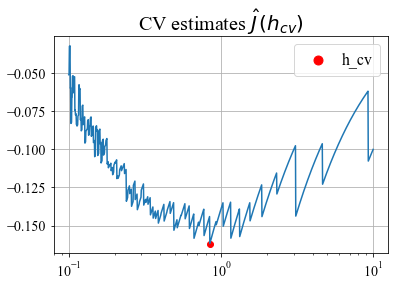

In [5]:
h_list = np.logspace(-1, 1, 1000)
cv_hist = [cross_validation_histogram(sample, hi) for hi in h_list]
plt.plot(h_list, cv_hist)
plt.title(r'CV estimates $\hatJ(h_{cv})$')
plt.scatter(h_list[np.argmin(cv_hist)], cross_validation_histogram(sample, h_list[np.argmin(cv_hist)]), c = 'r', label = 'h_cv')
plt.legend()
plt.grid(True)
plt.xscale("log")

In [6]:
print('Optimal bandwidth using leave-one-out CV:')
h_cv = h_list[np.argmin(cv_hist)]
print('h_cv = ', round(h_list[np.argmin(cv_hist)], 5))
print('J(h_cv) = ', round(cross_validation_histogram(sample, h_list[np.argmin(cv_hist)]), 5))

Optimal bandwidth using leave-one-out CV:
h_cv =  0.84514
J(h_cv) =  -0.16175


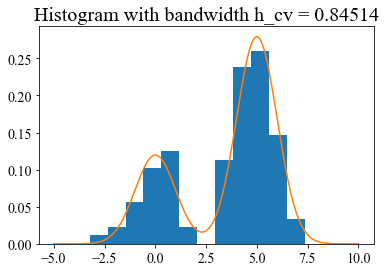

In [7]:
plt.hist(sample, bins=int((b-a)/h_list[np.argmin(cv_hist)]), range=(a, b), density=True)
plt.plot(x_values, true_pdf)
plt.title('Histogram with bandwidth h_cv = 0.84514')
plt.show()

In [8]:
def np_hist(h):
    m = (b - a) / h
    n = n_samples
    hist, _ = np.histogram(sample, int(m), range=(a, b))
    p = hist/n
    risk = 2 / (n - 1) / h- ((n + 1) * sum(p**2)) / ((n - 1) * h)
    return risk

In [9]:
risk_np = [np_hist(h) for h in h_list]

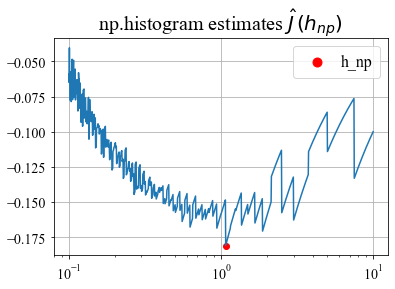

In [10]:
h_list = np.logspace(-1, 1, 1000)
cv_hist = [np_hist(hi) for hi in h_list]
plt.plot(h_list, risk_np)
plt.title(r'np.histogram estimates $\hatJ(h_{np})$')
plt.scatter(h_list[np.argmin(cv_hist)], np_hist(h_list[np.argmin(cv_hist)]), c = 'r', label = 'h_np')
plt.legend()
plt.grid(True)
plt.xscale("log")

In [11]:
print('Optimal bandwidth using np.histogram:')
print('h_np = ',np.round(h_list[np.argmin(risk_np)], 5))
print('J(h_np) = ',min(np.round(risk_np, 5)))

Optimal bandwidth using np.histogram:
h_np =  1.07407
J(h_np) =  -0.18085


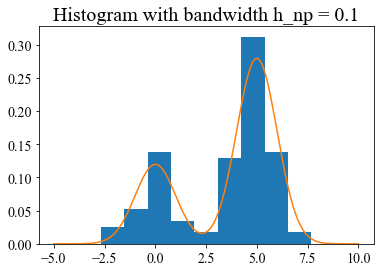

In [12]:
plt.hist(sample, bins=int((b-a)/h_list[np.argmin(risk_np)]), range=(a, b), density=True)
plt.plot(x_values, true_pdf)
plt.title('Histogram with bandwidth h_np = 0.1')
plt.show()

In [13]:
Oracle = 0.0804924 
h_star = (6/n_samples/Oracle)**(1/3)
print('Optimal bandwidth using formula from the lecture:')
print('h* = ', round(h_star,5))
print('J(h*) = ', round(cross_validation_histogram(sample, h_star), 4))

Optimal bandwidth using formula from the lecture:
h* =  0.9067
J(h*) =  -0.1508


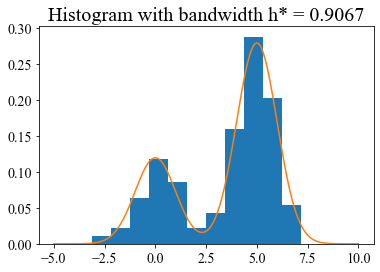

In [14]:
plt.hist(sample, bins=int((b-a)/h_star), range=(a, b), density=True)
plt.plot(x_values, true_pdf)
plt.title('Histogram with bandwidth h* = 0.9067')
plt.show()

In [15]:
#let's calculate relative error between h* and h_cv:

print(round((h_star - h_cv)/h_star*100,3))

6.79


As it can be seen these values are not equal to each other but similar. Looking on the histograms we can also see that h* approximates the real distribution the best. Also we calculated relative error between h* and h_cv and found out that it is equal to 6.79.

In [16]:
h_scott = np.histogram_bin_edges(sample, bins = 'scott')[1]- np.histogram_bin_edges(sample, bins = 'scott')[0]
h_doane = np.histogram_bin_edges(sample, bins = 'doane')[1]- np.histogram_bin_edges(sample, bins = 'doane')[0]
h_sturges = np.histogram_bin_edges(sample, bins = 'sturges')[1]- np.histogram_bin_edges(sample, bins = 'sturges')[0]


print('h_scott = ', round(h_scott,5))
print('h_doane = ', round(h_doane,5))
print('h_sturges = ', round(h_sturges,5))

h_scott =  1.54708
h_doane =  0.92825
h_sturges =  1.16031


As it can be seen estimated automatically bandwidths are also simillar to the h*, h_cv and h_np.

## Kernel density estimate

In this part, you will use the same sample, but employ the kernel density estimation method. We can use the same proxy expression to optimise the risk:
\begin{gather*}
J(h) = \int \hatp^2 \lp x;\xs{n} \rp dx - 2 \int \hatp \lp x;\xs{n} \rp p(x) dx
\end{gather*}

In out case of kernel estimator, we can obtain:
\begin{gather*}
\hatJ(h) = \frac{1}{hn^2}\Sum_{i = 1}^n\Sum_{j = 1}^n K^{(2)}\lp\frac{x_i - x_j}{h}\rp + \frac{K(0)}{nh}, \label{eq3}\tag{3}
\end{gather*}
where
\begin{gather*}
K^{(2)}(x) = K^*(x) - 2K(x), \quad K^*(x) = \int K(x - y) K(y) dy.
\end{gather*}

You can use [kernel density estimation from sklearn](http://scikit-learn.org/stable/modules/density.html). Your task is:
1. Build a kernel density estimate given the sample from before, tune bandwidth using leave-one-out CV. Try two different kernels of your choice. Use formula \ref{eq3} for your estimates (1 point)
2. Plot CV estimates $\hatJ(h)$ that you obtained during selection. Mark optimal bandwidth $h_{cv}$ and report $h_{cv}$ and $\hatJ(h_{cv})$. What kernel worked better in terms of estimated risk? (0.5 point)
3. Recall the approximation to $MISE$ from Lecture 7, slide 20. Assume an Oracle calculated the integral of the squared second derivative of the true density for you and the value is $0.127529$. What will be the approximate optimal bandwidth $h^*$? Find CV estimate of $J$ for this value of bandwidth and compare it to the one found in part 1 (0.5 point)

#### Gaussian kernel:

In [17]:
from math import *

def cross_validation_kernel(sample, h):
    n = len(sample)
    summ = 0
    K_0 = 1/(sqrt(2*pi))
    for i in range(n):
        for j in range(n):
            summ += 1/sqrt(4*pi)*exp(-((sample[i]-sample[j])**2)/(4*h**2))-2/sqrt(2*pi)*exp(-((sample[i]-sample[j])**2)/(2*h**2))
    return (summ/h/n**2 + 2*K_0/n/h)

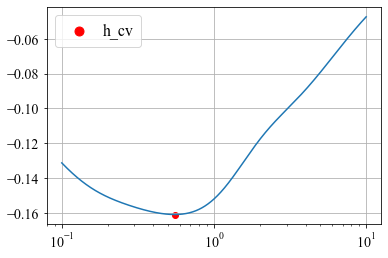

In [18]:
h_list = np.logspace(-1, 1, 1000)
cv_hist = [cross_validation_kernel(sample, hi) for hi in h_list]
plt.plot(h_list, cv_hist)
plt.scatter(h_list[np.argmin(cv_hist)], cross_validation_kernel(sample, h_list[np.argmin(cv_hist)]), c = 'r', label = 'h_cv')
plt.legend()
plt.grid(True)
plt.xscale("log")

In [19]:
print('h_cv_gauss = ', round(h_list[np.argmin(cv_hist)], 5))
print('J(h_cv_gauss) = ', round(cross_validation_kernel(sample, h_list[np.argmin(cv_hist)]), 5))

h_cv_gauss =  0.55048
J(h_cv_gauss) =  -0.16097


In [20]:
h_star = (len(sample)*2*sqrt(pi)*0.127529)**(-1/5)

print('h*_gauss = ', round(h_star, 5))
print('J(h*_gauss) = ', round(cross_validation_kernel(sample, h_star), 5))

h*_gauss =  0.46661
J(h*_gauss) =  -0.16056


#### Epanechnikov kernel:

In [21]:
def epanechnikov(x):
    if np.abs(x)>1:
        k = 0
    else:
        k = 3/4 * (1 - x**2)
    if np.abs(x)>2:
        return 0 
    if (x > 0) and (x < 2):
        return -9/(30*16) * (x - 2)**3 * (x**2 + 6*x + 4) - 2 * k
    elif (x > -2) and (x <= 0):
        return 9/(30*16) * (x + 2)**3 * (x**2 - 6*x + 4)- 2 * k


In [22]:
def cross_validation_kernel_ep(sample, h):
    n = len(sample)
    summ = 0
    K_0 = 3/4
    for i in range(n):
        for j in range(n):
                summ += epanechnikov((sample[i] - sample[j])/h)
    return (summ/h/n**2 + 2*K_0/n/h)

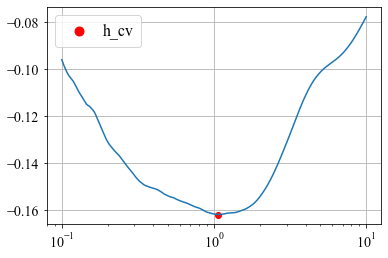

In [23]:
h_list = np.logspace(-1, 1, 1000)
cv_hist = [cross_validation_kernel_ep(sample, hi) for hi in h_list]
plt.plot(h_list, cv_hist)
plt.scatter(h_list[np.argmin(cv_hist)], cross_validation_kernel_ep(sample, h_list[np.argmin(cv_hist)]), c = 'r', label = 'h_cv')
plt.legend()
plt.grid(True)
plt.xscale("log")

In [24]:
print('h_cv_epanechnikov = ', round(h_list[np.argmin(cv_hist)], 5))
print('J(h_cv_epanechnikov) = ', round(cross_validation_kernel_ep(sample, h_list[np.argmin(cv_hist)]), 5))

h_cv_epanechnikov =  1.06913
J(h_cv_epanechnikov) =  -0.16196


In [25]:
n = 0
for i in range(len(sample)):
    if np.abs(sample[i])<1:
        n += 1 #to count only elements that are: |x|<1

h_star = (0.6/n_samples/0.04/0.127529)**(1/5)

print('h*_epanechnikov = ', round(h_star, 5))
print('J(h*_epanechnikov) = ', round(cross_validation_kernel_ep(sample, h_star), 5))

h*_epanechnikov =  1.03299
J(h*_epanechnikov) =  -0.16186


# Task 2. Non-parametric Regression (5.5 pt)

In this task you will apply non-parametric regression to airport statistics data.

### Data loading and preprocessing

Load dataset from `airport_operations_report.csv`. Use `General Aviation: Total Operations` as target(dependent) variable and `[Air Carrier Operations, General Aviation: Local Operations]` as covariates(independent variables). Divide $1^{st}$ covariate by `1000`, $2^{nd}$ by `100` and target by `1000`. Make 2D grid for covariates from minimum to maximum values with `100` steps along each dimension.

In [26]:
df = pd.read_csv("airport_operations_report.csv", sep=",")
target= ((df["General Aviation: Total Operations"].values)/1000)[:, None]
cov_1 = ((df["Air Carrier Operations"].values)/1000)[:, None]
cov_2 = ((df["General Aviation: Local Operations"].values)/100)[:, None]

l1 = np.linspace(min(cov_1), max(cov_1), 100, endpoint=False)
l2 = np.linspace(min(cov_2), max(cov_2), 100, endpoint=False)

grid = np.meshgrid(l1,l2)
grid = np.array([grid[0].flatten(),grid[1].flatten()]).T

sample_min, sample_max = np.hstack([np.min(cov_1),np.min(cov_2)]), np.hstack([np.max(cov_1),np.max(cov_2)])

### Fit model (1 pt)

Perform a nonparametric regression to fit the model $Y = f(x)+\varepsilon$. 

In [27]:
nw = KernelReg(target, np.hstack([cov_1,cov_2]), var_type="cc", reg_type="lc")

Predict values for created grid.

In [28]:
step_numbers = (100,100)
target_pred,_ = nw.fit(grid)
target_pred = target_pred.reshape(*step_numbers)
grid = grid.reshape(*step_numbers, 2)

In [29]:
minmax_values=np.vstack((sample_min, sample_max))

This is function to visualize 3D surfaces. You can modify it if you need.

In [30]:
def plot_surface_function(x1, x2, y, minmax_values=None, ax=None):
    
    if ax is None:
        fig = plt.figure()
        ax = fig.gca(projection='3d')

        surf = ax.plot_surface(x1, x2, y, cmap=cm.rainbow, linewidth=0.5, alpha=0.5, edgecolor="k")
        if minmax_values is not None:
            ax.set_xlim3d(*minmax_values[0])
            ax.set_ylim3d(*minmax_values[1])
    
    else:
        surf = ax.plot_surface(x1, x2, y, cmap=cm.bwr, linewidth=0.5, alpha=0.1, edgecolor="k")
        
    return ax

Let's plot estimated surface.

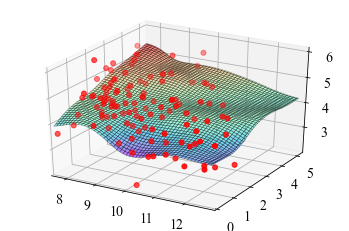

In [31]:
# target - dependent variable
# grid - grid for covariates
# sample - covariates

ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred, minmax_values=np.vstack((sample_min, sample_max)).T)
ax.scatter(np.hstack([cov_1,cov_2])[:, 0], np.hstack([cov_1,cov_2])[:, 1], target, marker="o", s=25, c="r")
plt.show()

### Estimate confidence intervals (2 pt)

Construct 95\% confidence bands for your estimate. To estimate error variance for 1D covariate, you sort your sample and subtract target values in the nearest points. For 2D covariate, you should, for each point, calculate the difference in target values between a point and its nearest neighbor(in euclidian metric). To get power for quantile of standard normal distribution, which is $\frac{w}{b-a}$ for 1D, estimate it per coordinate and multiply: $\prod_{i=1}^2 \frac{w_i}{b_i-a_i}$. 

In [32]:
from sklearn.metrics.pairwise import rbf_kernel
kernel = lambda x, y, h: rbf_kernel(x/h, y/h, 0.5) / (2 * np.pi)**(x.shape[1] / 2)

from sklearn.neighbors import NearestNeighbors

def prediction_se(grid, sample, target, h, alpha=0.05):
    n = target.shape[0]
    nbrs = NearestNeighbors(n_neighbors = 2, metric='euclidean').fit(sample)
    _, indices = nbrs.kneighbors(sample)
    
    sigma_hat2 = 0
    for i in range(len(target)):
        sigma_hat2 += ((target[i] - target[indices[:,1][i]])**2) / (2 * (n-1))
    

    delta1 = minmax_values[:,1][1]-minmax_values[:,1][0]
    delta2 = minmax_values[:,0][1]-minmax_values[:,0][0]
        
    kernel_values = kernel(grid, sample, h)
    
    kernel_sum = np.sum(kernel_values, axis=1, keepdims=True)

    nonzero_indices = kernel_sum[:, 0] > 1e-8
    kernel_weights = kernel_values
    kernel_weights[nonzero_indices] = kernel_weights[nonzero_indices] / kernel_sum[nonzero_indices]
    kernel_weights[~nonzero_indices] = 0    
        
    se = np.sqrt(np.sum(kernel_weights**2, axis=1) * sigma_hat2)
    m = (delta1 / (3 * h))*(delta2 / (3 * h))
    q = sps.norm.ppf((1+(1-alpha)**(1/m))/2)
    return q*se

In [33]:
# Your code here

qse = prediction_se(grid.reshape(10000,2),  np.hstack([cov_1,cov_2]), target, h = 1)
qse = qse.reshape(*step_numbers)

Let's plot confidence intervals

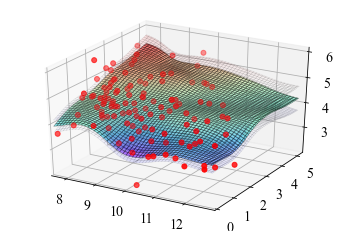

In [34]:
sample = np.hstack([cov_1,cov_2])

ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred, minmax_values=np.vstack((sample_min, sample_max)).T)
ax.scatter(sample[:, 0], sample[:, 1], target, marker="o", s=25, c="r")
ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred + qse, ax=ax)
ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred - qse, ax=ax)

### Find optimal bandwidth (2 pt)

Use cross-validation to estimate the bandwidth.

In [35]:
def cross_validation_regression(sample, target, h):

    n = sample.shape[0]
    mask = np.ones(n, dtype=np.bool_)
    h_0, h_1 = h[0],h[1]
    bw = np.r_[h_0, h_1]
    summ = 0
    for i in range(n):
        mask[i] = False
        nw = KernelReg(target[mask], sample[mask], var_type="cc", reg_type="lc", bw=bw)
        mask[i] = True
        temp = nw.fit(sample[i].reshape(2, 1))[0]
        summ += (target[i] - temp)**2
        summ = summ.item()
    return summ

Make grid with logarithm step to find best bandwidth, from `0.1` to `10` with `21` steps along each dimension. Visualize obrained results with `plot_surface_function`. Print values for optimal bandwidth.

In [36]:
xx, yy = np.meshgrid(np.logspace(-1, 1, 21), np.logspace(-1, 1, 21))
h_ = np.c_[xx.reshape(-1, 1), yy.reshape(-1, 1)]

In [37]:
cv_hist = np.array([cross_validation_regression(np.hstack([cov_1,cov_2]), target, h_[hi]) for hi in range(h_.shape[0])])

In [38]:
print('Optimal bandwidth: ',h_[np.argmin(cv_hist)][0])

Optimal bandwidth:  0.5011872336272724


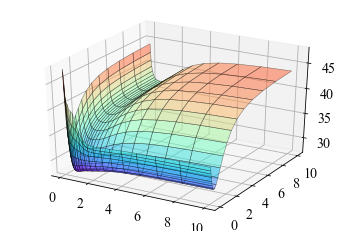

In [39]:
ax = plot_surface_function(h_[:len(cv_hist),0].reshape(-1, 21), h_[:len(cv_hist),1].reshape(-1, 21), cv_hist.reshape(-1, 21))

Plot surface with estimated bandwidth.

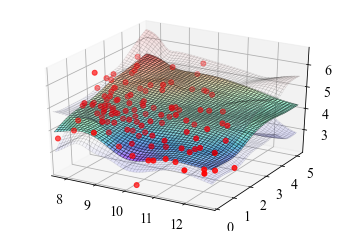

In [40]:
qse = prediction_se(grid.reshape(10000,2),  np.hstack([cov_1,cov_2]), target, h = h_[np.argmin(cv_hist)][0])
qse = qse.reshape(*step_numbers)

sample = np.hstack([cov_1,cov_2])

ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred, minmax_values=np.vstack((sample_min, sample_max)).T)
ax.scatter(sample[:, 0], sample[:, 1], target, marker="o", s=25, c="r")
ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred + qse, ax=ax)
ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred - qse, ax=ax)

### Conclusion (0.5 pt)

As we can see confidence intervals differ in these two cases (with optimal bandwidth equal to 0.501187 and with not optimal equal to 1).

Also if we take smaller bandwidth our model is under-trainined, larger - over-trainined.

# Task 3. Model Selection (5.5 pt)

In this task you will select model(choose set of covariates) using AIC criteria and forward/backward stepwise regression.

While doing this task I used code from https://xavierbourretsicotte.github.io/subset_selection.html#Comparing-models:-AIC,-BIC,-Mallows'CP .

### Data loading and preprocessing

Read dataset `pacn_wrcc.csv`. The target variable is `ly Solar Rad.`, others are covariates.

In [41]:
pacn_wrcc = pd.read_csv("pacn_wrcc.csv", sep=",")
target = pacn_wrcc['ly Solar Rad.']
covariatives = pacn_wrcc.drop(['ly Solar Rad.'],axis=1)

pacn_wrcc.head()

,mph Wind Speed,Deg Wind Direc,Deg F Av Air Temp,% Rel Humidty,volts Battery Voltage,Deg Dir MxGust,mph Mx Gust Speed,ly Solar Rad.,Deg F Mn Air Temp,Deg F Mx Air Temp,"Deg F 2"" Soil Ave Tmp","Deg F 4"" Soil Ave Tmp","Deg F 8"" Soil Av Temp","Deg F 20""Soil Av Temp"
0,4.428,49.35,59.96,88.2,12.52,85.0,16.24,5.748000,59.37,60.33,64.28,61.68,61.85,61.37
1,4.347,30.13,59.33,91.2,12.33,40.0,16.37,0.218700,58.52,59.73,63.61,61.77,61.65,61.25
2,4.592,35.97,58.60,89.7,12.26,163.0,21.54,0.007225,58.34,58.84,62.90,61.80,61.57,61.20
3,4.264,19.19,58.33,88.9,12.24,35.0,17.34,0.009203,58.05,58.72,62.36,61.74,61.47,61.14
4,3.755,8.62,58.19,89.6,12.22,164.0,16.89,0.006709,57.87,58.53,61.79,61.72,61.47,61.12


Scale covariates to range `[0, 1]` and add bias column.

In [42]:
# scale 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
covariatives[covariatives.columns] = scaler.fit_transform(covariatives)

biases =  covariatives-covariatives.mean()
covariatives['bias'] = biases.sum(axis=1)

In [43]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

from tqdm import tnrange, tqdm_notebook
import itertools
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [44]:
X = covariatives
y = target

k = X.shape[1]

X.head()

,mph Wind Speed,Deg Wind Direc,Deg F Av Air Temp,% Rel Humidty,volts Battery Voltage,Deg Dir MxGust,mph Mx Gust Speed,Deg F Mn Air Temp,Deg F Mx Air Temp,"Deg F 2"" Soil Ave Tmp","Deg F 4"" Soil Ave Tmp","Deg F 8"" Soil Av Temp","Deg F 20""Soil Av Temp",bias
0,0.385036,0.137073,0.452415,0.709667,0.289256,0.232493,0.455965,0.492595,0.414765,0.567308,0.392435,0.485915,0.430556,-0.107039
1,0.372742,0.083667,0.407670,0.808644,0.132231,0.106443,0.461701,0.426345,0.374497,0.513622,0.413712,0.415493,0.347222,-0.688530
2,0.409926,0.099894,0.355824,0.759155,0.074380,0.450980,0.689816,0.412315,0.314765,0.456731,0.420804,0.387324,0.312500,-0.408104
3,0.360146,0.053268,0.336648,0.732761,0.057851,0.092437,0.504501,0.389712,0.306711,0.413462,0.406619,0.352113,0.270833,-1.275458
4,0.282896,0.023897,0.326705,0.755856,0.041322,0.453782,0.484645,0.375682,0.293960,0.367788,0.401891,0.352113,0.256944,-1.135038


### Cp Mallow and sample variance (2 pt)

Estimate sample variance of error with full set of covariates. Take into account number of dependent variables.

In [45]:
model_k = linear_model.LinearRegression(fit_intercept = True)
model_k.fit(X,y)
RSS = mean_squared_error(y,model_k.predict(X)) * len(y)

In [46]:
sigma2 = (1/(len(y) - X.shape[1]))*RSS

Implement estimate of AIC for given covariates, target and error variance.

In [47]:
def Cp(X, y, sigma2):
    
    b_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    y_i = X@beta_hat
    
    RSS = mean_squared_error(y, y_i) * len(y)
    
    cp_list = (1/len(y)) * (RSS + 2 * X.shape[1] * sigma2 )

    return cp_list

### Forward stepwise regression (1 pt)

Implement forward stepwise regression. Save the order in which covariates are added to feature set and AIC values for those feature sets.

In [48]:
def fit_linear_reg(X,Y, alpha=0.):
    if  alpha==0:
        #Fit linear regression model and return RSS and R squared values
        model_k = linear_model.LinearRegression(fit_intercept = True)
        model_k.fit(X,Y)
        RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
        R_squared = model_k.score(X,Y)
    else:
        model_k = linear_model.Ridge(fit_intercept = True, alpha=alpha)
        model_k.fit(X,Y)
        RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
        R_squared = model_k.score(X,Y)
    return RSS, R_squared

In [49]:
def forward_stepwise_regression(X, y, sigma2, alpha=0.):
    # Forward stepwise selection
    
    remaining_features = list(X.columns.values)
    features = []
    RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
    features_list = dict()
    
    k = X.shape[1]
    
    for i in range(1,k+1):
        best_RSS = np.inf

        for combo in itertools.combinations(remaining_features,1):

                RSS = fit_linear_reg(X[list(combo) + features], y, alpha)   #Store temp result 

                if RSS[0] < best_RSS:
                    best_RSS = RSS[0]
                    best_R_squared = RSS[1] 
                    best_feature = combo[0]

        #Updating variables for next loop
        features.append(best_feature)
        remaining_features.remove(best_feature)

        #Saving values for plotting
        RSS_list.append(best_RSS)
        R_squared_list.append(best_R_squared)
        features_list[i] = features.copy()
    
    numb_features = list(features_list.keys())
    
    cp_list = (1/len(y)) * (np.array(RSS_list[1:] + 2 * np.array(numb_features) * sigma2 ))

    return features_list, cp_list

In [50]:
features, cp_list = forward_stepwise_regression(X, y, sigma2)
for a, cp_value in enumerate(cp_list, 1):
    print(f"C_p {cp_value:.3f} +{features[a]}")

C_p 63.468 +['Deg F Mx Air Temp']
C_p 55.080 +['Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp']
C_p 48.200 +['Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp', 'bias']
C_p 40.853 +['Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp', 'bias', '% Rel Humidty']
C_p 35.715 +['Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp', 'bias', '% Rel Humidty', 'volts Battery Voltage']
C_p 32.591 +['Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp', 'bias', '% Rel Humidty', 'volts Battery Voltage', 'mph Mx Gust Speed']
C_p 31.174 +['Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp', 'bias', '% Rel Humidty', 'volts Battery Voltage', 'mph Mx Gust Speed', 'Deg F Av Air Temp']
C_p 29.570 +['Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp', 'bias', '% Rel Humidty', 'volts Battery Voltage', 'mph Mx Gust Speed', 'Deg F Av Air Temp', 'Deg F Mn Air Temp']
C_p 29.434 +['Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp', 'bias', '% Rel Humidty', 'volts Battery Voltage', 'mph Mx Gust Speed', 'Deg F Av Air Temp', 'Deg F Mn Air Temp', 'Deg F 2" Soil Ave Tmp

### Backward stepwise regression (1 pt)

Implement backward stepwise regression. Save the order in which covariates are removed from feature set and AIC values for those feature sets.

In [51]:
def backward_stepwise_regression(X, y, sigma2, alpha=0.):
    
    remaining_features = list(X.columns.values)


    RSS_orid, R_2_orig = fit_linear_reg(X[remaining_features], y, alpha)
    RSS_list, R_squared_list = [RSS_orid], [R_2_orig] #Due to 1 indexing of the loop...
    features = []
    features_list = dict()

    k = X.shape[1]

    features_list[k] = remaining_features.copy()
    for i in range(k,1,-1):
        best_RSS = np.inf
        for combo in itertools.combinations(remaining_features,1):
            current_features = remaining_features.copy()
            current_features.remove(list(combo)[0])
            RSS = fit_linear_reg(X[current_features], y, alpha)   #Store temp result 
            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]
        #Updating variables for next loop
        features.append(best_feature)
        remaining_features.remove(best_feature)

        #Saving values for plotting
        RSS_list.append(best_RSS)
        R_squared_list.append(best_R_squared)
        features_list[i-1] = remaining_features.copy()

    
    numb_features = list(features_list.keys())

    cp_list = (1/len(y)) * (np.array(RSS_list + 2 * np.array(numb_features) * sigma2 ))
    
    return features_list, reversed(cp_list)

In [52]:
features, cp_list = backward_stepwise_regression(X, y, sigma2)
for a, cp_value in enumerate(cp_list, 1):
    print(f"C_p {cp_value:.3f} +{features[a]}")

C_p 72.116 +['Deg F Av Air Temp']
C_p 60.671 +['Deg F Av Air Temp', 'volts Battery Voltage']
C_p 54.872 +['Deg F Av Air Temp', 'volts Battery Voltage', 'mph Mx Gust Speed']
C_p 51.640 +['Deg F Av Air Temp', 'volts Battery Voltage', 'mph Mx Gust Speed', 'Deg F 20"Soil Av Temp']
C_p 47.516 +['Deg F Av Air Temp', 'volts Battery Voltage', 'mph Mx Gust Speed', 'Deg F 20"Soil Av Temp', 'bias']
C_p 41.965 +['Deg Wind Direc', 'Deg F Av Air Temp', 'volts Battery Voltage', 'mph Mx Gust Speed', 'Deg F 20"Soil Av Temp', 'bias']
C_p 36.425 +['Deg Wind Direc', 'Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'mph Mx Gust Speed', 'Deg F 20"Soil Av Temp', 'bias']
C_p 34.256 +['mph Wind Speed', 'Deg Wind Direc', 'Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'mph Mx Gust Speed', 'Deg F 20"Soil Av Temp', 'bias']
C_p 31.262 +['mph Wind Speed', 'Deg Wind Direc', 'Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'mph Mx Gust Speed', 'Deg F 2" Soil Ave Tmp', 'De

### Bruteforce (1 pt)

Find best sets of covariates and their AIC for all sizes of feature sets.

In [53]:
def bruteforce(X, y, sigma2, alpha=0.):
    
    k = X.shape[1]
    
    RSS_list, R_squared_list, feature_list = [],[], []
    numb_features = []

    #Looping over k = 1 to k = 11 features|in X
    for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):

        #Looping over all possible combinations: from 13 choose k
        for combo in itertools.combinations(X.columns,k):
            tmp_result = fit_linear_reg(X[list(combo)], y, alpha)   #Store temp result 
            RSS_list.append(tmp_result[0])                  #Append lists
            R_squared_list.append(tmp_result[1])
            feature_list.append(combo)
            numb_features.append(len(combo))   
    
    sigma2 = (1/(len(y) - np.array(numb_features) -1)) * np.array(RSS_list) 
#     sigma2 = (1/(len(y) - X.shape[1] -1)) * np.min(RSS_list)
    
    cp_list = (1/len(y)) * (np.array(RSS_list) + 2 * np.array(numb_features) * sigma2 )

    return feature_list, cp_list


In [54]:
features, cp_list = bruteforce(X, y, sigma2)
for a, cp_value in enumerate(cp_list):
    print(f"C_p {cp_value:.3f} -{features[a]}")


C_p 313.400 -('mph Wind Speed',)
C_p 304.653 -('Deg Wind Direc',)
C_p 72.408 -('Deg F Av Air Temp',)
C_p 208.341 -('% Rel Humidty',)
C_p 106.076 -('volts Battery Voltage',)
C_p 310.123 -('Deg Dir MxGust',)
C_p 300.729 -('mph Mx Gust Speed',)
C_p 100.933 -('Deg F Mn Air Temp',)
C_p 63.702 -('Deg F Mx Air Temp',)
C_p 279.515 -('Deg F 2" Soil Ave Tmp',)
C_p 253.823 -('Deg F 4" Soil Ave Tmp',)
C_p 252.620 -('Deg F 8" Soil Av Temp',)
C_p 309.767 -('Deg F 20"Soil Av Temp',)
C_p 202.544 -('bias',)
C_p 305.983 -('mph Wind Speed', 'Deg Wind Direc')
C_p 63.897 -('mph Wind Speed', 'Deg F Av Air Temp')
C_p 208.788 -('mph Wind Speed', '% Rel Humidty')
C_p 100.972 -('mph Wind Speed', 'volts Battery Voltage')
C_p 311.327 -('mph Wind Speed', 'Deg Dir MxGust')
C_p 299.676 -('mph Wind Speed', 'mph Mx Gust Speed')
C_p 91.452 -('mph Wind Speed', 'Deg F Mn Air Temp')
C_p 56.227 -('mph Wind Speed', 'Deg F Mx Air Temp')
C_p 275.281 -('mph Wind Speed', 'Deg F 2" Soil Ave Tmp')
C_p 254.875 -('mph Wind Speed',

C_p 52.260 -('mph Wind Speed', 'Deg Wind Direc', '% Rel Humidty', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp')
C_p 47.132 -('mph Wind Speed', 'Deg Wind Direc', '% Rel Humidty', 'Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp')
C_p 50.531 -('mph Wind Speed', 'Deg Wind Direc', '% Rel Humidty', 'Deg F Mx Air Temp', 'Deg F 8" Soil Av Temp')
C_p 51.780 -('mph Wind Speed', 'Deg Wind Direc', '% Rel Humidty', 'Deg F Mx Air Temp', 'Deg F 20"Soil Av Temp')
C_p 53.633 -('mph Wind Speed', 'Deg Wind Direc', '% Rel Humidty', 'Deg F Mx Air Temp', 'bias')
C_p 85.160 -('mph Wind Speed', 'Deg Wind Direc', '% Rel Humidty', 'Deg F 2" Soil Ave Tmp', 'Deg F 4" Soil Ave Tmp')
C_p 127.530 -('mph Wind Speed', 'Deg Wind Direc', '% Rel Humidty', 'Deg F 2" Soil Ave Tmp', 'Deg F 8" Soil Av Temp')
C_p 150.488 -('mph Wind Speed', 'Deg Wind Direc', '% Rel Humidty', 'Deg F 2" Soil Ave Tmp', 'Deg F 20"Soil Av Temp')
C_p 110.920 -('mph Wind Speed', 'Deg Wind Direc', '% Rel Humidty', 'Deg F 2" Soil Ave Tmp', 'bias')
C_p 156

C_p 52.475 -('Deg F Av Air Temp', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 4" Soil Ave Tmp', 'Deg F 8" Soil Av Temp')
C_p 47.681 -('Deg F Av Air Temp', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 4" Soil Ave Tmp', 'Deg F 20"Soil Av Temp')
C_p 48.946 -('Deg F Av Air Temp', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 4" Soil Ave Tmp', 'bias')
C_p 47.746 -('Deg F Av Air Temp', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'Deg F 20"Soil Av Temp')
C_p 52.403 -('Deg F Av Air Temp', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'bias')
C_p 56.800 -('Deg F Av Air Temp', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 20"Soil Av Temp', 'bias')
C_p 47.954 -('Deg F Av Air Temp', 'Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'Deg F 20"Soil Av Temp')
C_p 48.547 -('Deg F Av Air Temp', 'Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'bias')
C_p 47.142 -('Deg F Av Air T

C_p 50.860 -('mph Wind Speed', 'Deg Wind Direc', 'Deg F Av Air Temp', 'Deg Dir MxGust', 'Deg F 2" Soil Ave Tmp', 'Deg F 4" Soil Ave Tmp')
C_p 54.480 -('mph Wind Speed', 'Deg Wind Direc', 'Deg F Av Air Temp', 'Deg Dir MxGust', 'Deg F 2" Soil Ave Tmp', 'Deg F 8" Soil Av Temp')
C_p 56.729 -('mph Wind Speed', 'Deg Wind Direc', 'Deg F Av Air Temp', 'Deg Dir MxGust', 'Deg F 2" Soil Ave Tmp', 'Deg F 20"Soil Av Temp')
C_p 57.423 -('mph Wind Speed', 'Deg Wind Direc', 'Deg F Av Air Temp', 'Deg Dir MxGust', 'Deg F 2" Soil Ave Tmp', 'bias')
C_p 50.064 -('mph Wind Speed', 'Deg Wind Direc', 'Deg F Av Air Temp', 'Deg Dir MxGust', 'Deg F 4" Soil Ave Tmp', 'Deg F 8" Soil Av Temp')
C_p 47.362 -('mph Wind Speed', 'Deg Wind Direc', 'Deg F Av Air Temp', 'Deg Dir MxGust', 'Deg F 4" Soil Ave Tmp', 'Deg F 20"Soil Av Temp')
C_p 48.028 -('mph Wind Speed', 'Deg Wind Direc', 'Deg F Av Air Temp', 'Deg Dir MxGust', 'Deg F 4" Soil Ave Tmp', 'bias')
C_p 44.775 -('mph Wind Speed', 'Deg Wind Direc', 'Deg F Av Air Temp'

C_p 50.320 -('Deg Wind Direc', 'Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F Mn Air Temp', 'Deg F 20"Soil Av Temp')
C_p 50.875 -('Deg Wind Direc', 'Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F Mn Air Temp', 'bias')
C_p 46.991 -('Deg Wind Direc', 'Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp')
C_p 47.687 -('Deg Wind Direc', 'Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp')
C_p 56.871 -('Deg Wind Direc', 'Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F Mx Air Temp', 'Deg F 8" Soil Av Temp')
C_p 53.191 -('Deg Wind Direc', 'Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F Mx Air Temp', 'Deg F 20"Soil Av Temp')
C_p 55.745 -('Deg Wind Direc', 'Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F Mx Air Temp', 'bias')
C_p 46.000 -('Deg Wind Direc', 'Deg F Av Air Te

C_p 39.919 -('% Rel Humidty', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp', 'Deg F 8" Soil Av Temp')
C_p 39.136 -('% Rel Humidty', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp', 'Deg F 20"Soil Av Temp')
C_p 35.378 -('% Rel Humidty', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp', 'bias')
C_p 38.583 -('% Rel Humidty', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F Mx Air Temp', 'Deg F 8" Soil Av Temp', 'Deg F 20"Soil Av Temp')
C_p 43.982 -('% Rel Humidty', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F Mx Air Temp', 'Deg F 8" Soil Av Temp', 'bias')
C_p 45.232 -('% Rel Humidty', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F Mx Air Temp', 'Deg F 20"Soil Av Temp', 'bias')
C_p 45.768 -('% Rel Humidty', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F 2" Soil Ave Tmp', 'Deg F 4" Soil Ave Tmp', 'Deg F 8" Soil Av Temp')
C_p 44.216 -('% Rel Humidty', 'volts Ba

C_p 39.688 -('mph Wind Speed', 'Deg F Av Air Temp', 'volts Battery Voltage', 'mph Mx Gust Speed', 'Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp', 'Deg F 20"Soil Av Temp')
C_p 41.177 -('mph Wind Speed', 'Deg F Av Air Temp', 'volts Battery Voltage', 'mph Mx Gust Speed', 'Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp', 'bias')
C_p 41.192 -('mph Wind Speed', 'Deg F Av Air Temp', 'volts Battery Voltage', 'mph Mx Gust Speed', 'Deg F Mx Air Temp', 'Deg F 8" Soil Av Temp', 'Deg F 20"Soil Av Temp')
C_p 47.518 -('mph Wind Speed', 'Deg F Av Air Temp', 'volts Battery Voltage', 'mph Mx Gust Speed', 'Deg F Mx Air Temp', 'Deg F 8" Soil Av Temp', 'bias')
C_p 44.255 -('mph Wind Speed', 'Deg F Av Air Temp', 'volts Battery Voltage', 'mph Mx Gust Speed', 'Deg F Mx Air Temp', 'Deg F 20"Soil Av Temp', 'bias')
C_p 40.131 -('mph Wind Speed', 'Deg F Av Air Temp', 'volts Battery Voltage', 'mph Mx Gust Speed', 'Deg F 2" Soil Ave Tmp', 'Deg F 4" Soil Ave Tmp', 'Deg F 8" Soil Av Temp')
C_p 40.224 -('mph Wind Speed', 'D

C_p 45.210 -('Deg Wind Direc', 'Deg Dir MxGust', 'mph Mx Gust Speed', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 4" Soil Ave Tmp', 'Deg F 20"Soil Av Temp')
C_p 47.559 -('Deg Wind Direc', 'Deg Dir MxGust', 'mph Mx Gust Speed', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 4" Soil Ave Tmp', 'bias')
C_p 45.589 -('Deg Wind Direc', 'Deg Dir MxGust', 'mph Mx Gust Speed', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'Deg F 20"Soil Av Temp')
C_p 50.386 -('Deg Wind Direc', 'Deg Dir MxGust', 'mph Mx Gust Speed', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'bias')
C_p 50.279 -('Deg Wind Direc', 'Deg Dir MxGust', 'mph Mx Gust Speed', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 20"Soil Av Temp', 'bias')
C_p 45.935 -('Deg Wind Direc', 'Deg Dir MxGust', 'mph Mx Gust Speed', 'Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'Deg F 20"Soil Av Temp')
C_p 47.293 -('Deg Wind Direc', 'Deg Dir MxGust', 'mph M

C_p 41.958 -('mph Wind Speed', 'Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'mph Mx Gust Speed', 'Deg F Mn Air Temp', 'Deg F Mx Air Temp', 'Deg F 8" Soil Av Temp')
C_p 44.022 -('mph Wind Speed', 'Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'mph Mx Gust Speed', 'Deg F Mn Air Temp', 'Deg F Mx Air Temp', 'Deg F 20"Soil Av Temp')
C_p 40.595 -('mph Wind Speed', 'Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'mph Mx Gust Speed', 'Deg F Mn Air Temp', 'Deg F Mx Air Temp', 'bias')
C_p 37.269 -('mph Wind Speed', 'Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'mph Mx Gust Speed', 'Deg F Mn Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 4" Soil Ave Tmp')
C_p 38.282 -('mph Wind Speed', 'Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'mph Mx Gust Speed', 'Deg F Mn Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 8" Soil Av Temp')
C_p 39.146 -('mph Wind Speed', 'Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust',

C_p 41.572 -('Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F Mn Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 4" Soil Ave Tmp', 'Deg F 20"Soil Av Temp', 'bias')
C_p 42.480 -('Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F Mn Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'Deg F 20"Soil Av Temp', 'bias')
C_p 41.595 -('Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F Mn Air Temp', 'Deg F 4" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'Deg F 20"Soil Av Temp', 'bias')
C_p 44.265 -('Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 4" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'Deg F 20"Soil Av Temp')
C_p 44.297 -('Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 4" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'bias')
C_p 44.059 -('Deg F Av Air Temp', 'volts Battery Voltage', 'Deg Dir MxGust', '

C_p 35.205 -('mph Wind Speed', 'Deg Wind Direc', '% Rel Humidty', 'mph Mx Gust Speed', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 4" Soil Ave Tmp', 'Deg F 20"Soil Av Temp', 'bias')
C_p 36.118 -('mph Wind Speed', 'Deg Wind Direc', '% Rel Humidty', 'mph Mx Gust Speed', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'Deg F 20"Soil Av Temp', 'bias')
C_p 36.472 -('mph Wind Speed', 'Deg Wind Direc', '% Rel Humidty', 'mph Mx Gust Speed', 'Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'Deg F 20"Soil Av Temp', 'bias')
C_p 38.170 -('mph Wind Speed', 'Deg Wind Direc', '% Rel Humidty', 'mph Mx Gust Speed', 'Deg F 2" Soil Ave Tmp', 'Deg F 4" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'Deg F 20"Soil Av Temp', 'bias')
C_p 37.747 -('mph Wind Speed', 'Deg Wind Direc', '% Rel Humidty', 'Deg F Mn Air Temp', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 4" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'Deg F 20"Soil Av Temp')
C_p 37.155 -('mph Wind S

C_p 32.236 -('Deg Wind Direc', 'Deg F Av Air Temp', '% Rel Humidty', 'volts Battery Voltage', 'mph Mx Gust Speed', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'Deg F 20"Soil Av Temp', 'bias')
C_p 31.687 -('Deg Wind Direc', 'Deg F Av Air Temp', '% Rel Humidty', 'volts Battery Voltage', 'mph Mx Gust Speed', 'Deg F Mx Air Temp', 'Deg F 4" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'Deg F 20"Soil Av Temp', 'bias')
C_p 30.992 -('Deg Wind Direc', 'Deg F Av Air Temp', '% Rel Humidty', 'volts Battery Voltage', 'mph Mx Gust Speed', 'Deg F 2" Soil Ave Tmp', 'Deg F 4" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'Deg F 20"Soil Av Temp', 'bias')
C_p 33.750 -('Deg Wind Direc', 'Deg F Av Air Temp', '% Rel Humidty', 'volts Battery Voltage', 'Deg F Mn Air Temp', 'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp', 'Deg F 4" Soil Ave Tmp', 'Deg F 8" Soil Av Temp', 'Deg F 20"Soil Av Temp')
C_p 32.066 -('Deg Wind Direc', 'Deg F Av Air Temp', '% Rel Humidty', 'volts Battery Voltage', 'Deg F Mn

### Conclusion (0.5 pt)
(partially from the Wasserman book)

If there are k covariates then there are $2^k$ possible models. We need to iterate over all of these models, assign a score to each of them, and select the model with the best score. When k is too large, this is impossible. Hence, we can't make Bruteforce.

In this case, we better search trough a subset of all models. There are two possible ways: forward and backward regression. In forward stepwise regression we start with no covariates in the model. We then add one variable that gives the best result. Continue adding variables one at a time until the result improves. Backward step by step regression is similar, except we start with the largest model and discard one variable at a time. Both are greedy searches; the second one is guaranteed to find the model with the best result. Another popular method is to randomly search the set of all models. 

# Task 4. Local regression (6 points)

In [55]:
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.linear_model import LogisticRegression

In [56]:
X = np.array([-3.        , -2.93939394, -2.87878788, -2.81818182, -2.75757576,
       -2.6969697 , -2.63636364, -2.57575758, -2.51515152, -2.45454545,
       -2.39393939, -2.33333333, -2.27272727, -2.21212121, -2.15151515,
       -2.09090909, -2.03030303, -1.96969697, -1.90909091, -1.84848485,
       -1.78787879, -1.72727273, -1.66666667, -1.60606061, -1.54545455,
       -1.48484848, -1.42424242, -1.36363636, -1.3030303 , -1.24242424,
       -1.18181818, -1.12121212, -1.06060606, -1.        , -0.93939394,
       -0.87878788, -0.81818182, -0.75757576, -0.6969697 , -0.63636364,
       -0.57575758, -0.51515152, -0.45454545, -0.39393939, -0.33333333,
       -0.27272727, -0.21212121, -0.15151515, -0.09090909, -0.03030303,
        0.03030303,  0.09090909,  0.15151515,  0.21212121,  0.27272727,
        0.33333333,  0.39393939,  0.45454545,  0.51515152,  0.57575758,
        0.63636364,  0.6969697 ,  0.75757576,  0.81818182,  0.87878788,
        0.93939394,  1.        ,  1.06060606,  1.12121212,  1.18181818,
        1.24242424,  1.3030303 ,  1.36363636,  1.42424242,  1.48484848,
        1.54545455,  1.60606061,  1.66666667,  1.72727273,  1.78787879,
        1.84848485,  1.90909091,  1.96969697,  2.03030303,  2.09090909,
        2.15151515,  2.21212121,  2.27272727,  2.33333333,  2.39393939,
        2.45454545,  2.51515152,  2.57575758,  2.63636364,  2.6969697 ,
        2.75757576,  2.81818182,  2.87878788,  2.93939394,  3.        ])

In [57]:
Y = np.array([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

You are given a sample of pairs $(X_i, Y_i)$. The output variable appers to be binary. We know a model for this type of data: logistic regression. In this model we assume the log-odds of the Bernoulli output variable to be a linear function:
$$\mathbb{P}(Y_i = 1 | X_i = x_i) = p(x_i) = \frac{e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}$$
Lets fit a standard logistic regression to the data:

In [58]:
logreg = LogisticRegression(penalty='none')
logreg.fit(X.reshape(-1, 1), Y)
p_pred_global = logreg.predict_proba(X.reshape(-1, 1))[:, 1]
print(f"Coefficients of the fitted logistic regression model: b0={logreg.intercept_[0]}, b1={logreg.coef_[0][0]}")

Coefficients of the fitted logistic regression model: b0=0.3769839468432626, b1=0.9109286874944


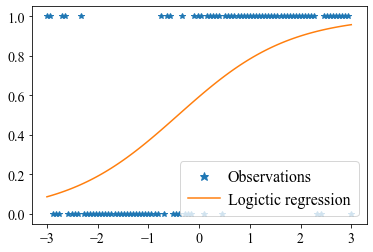

In [59]:
plt.plot(X, Y, '*', label='Observations')
plt.plot(X, p_pred_global, label='Logictic regression')
plt.legend()

## Local regression

As we can see, the dependence of the outcome on $x$ looks more complex than estimated using logistic regression. We will try to improve it with local regression methods instead.
Instead of a global model, we will approximate conditinal probability of the positive class in a neighbourhood of $x$ with:
$$p(u) \approx \frac{e^{\beta_0 + \beta_1 (u-x) }}{1 + e^{\beta_0 + \beta_1 (u-x)}}, $$
for $u$ close to $x$. The coefficients in this case will depend on $x$. To find them, we will have to fit a (slightly different) model at each new query point $x_{new}$ (point where we want to predict $Y$). We will also need to introduce a notion of 'closenes' of points across $x$ - for this we can use our familiar *kernel functions*. Bringing everything together, we introduce the following local loglikelihood for our proposed model:
$$\ell_x(\beta) = \sum\limits_{i=1}^{n} K\left(\frac{x-X_i}{h}\right)\ell\left(Y_i, \beta_0 + \beta_1 \left(X_i - x\right)\right) = \sum\limits_{i=1}^{n} K\left(\frac{x-X_i}{h}\right) \left(Y_i \left(\beta_0 + \beta_1 \left(X_i - x\right)\right) - \log \left( 1 + e^{\beta_0 + \beta_1 \left(X_i - x\right)} \right) \right),$$
$$\ell(y, z) = yz - \log \left(1 + e^z \right).$$
Here $\ell(y, z)$ is a log-likelohood for a single Bernoulli with log-dds ratio $z = \frac{p}{1-p}$. The local log-likelihood $\ell_x(\beta)$ should be optimized numerically to each new point $x$ to obtain $\widehat{\beta}(x)=(\widehat{\beta_0}(x), \widehat{\beta_1}(x))$. Then, we can predict $Y$ using the logistic model:
$$ \mathbb{P}(Y=1 | X=x) = \frac{e^{\beta_0(x)}}{1 + e^{\beta_0(x)}}.$$
Your task is:
1. Implement the proposed local logistic regression approach using Gaussian kernel. *Hint*: look at additional parameters of the `fit` method of [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) from `sklearn` package (2 points)
2. Select optimal bandwidth using leave-one-out log-likelihood cross-validation: $\ell_{cv} = \sum_i \ell(Y_i, \widehat{z}_{-i}(x_i))$, where $\widehat{z}_{-i}$ is the estimated log-odds ratio without $i$th sample (3 points)
3. Now ignore that the output variable is binary. Compare previous results with local linear kernel regression method using `KernelReg` from `statsmodels`. Use leave-one out squared error cross-validation to select the bandwidth (1 bonus point)

__4.1__

In [60]:
#The code from this cell was partially taken from:
#https://towardsdatascience.com/kernel-regression-from-scratch-in-python-ea0615b23918

import math
class GKR:
    
    def __init__(self, x, y, h):
        self.x = x
        self.y = y
        self.h = h
    
    def gaussian_kernel(self, z):
        return (1/math.sqrt(2*math.pi))*math.exp(-0.5*z**2)
    
    def predict(self, X):
        kernels = [self.gaussian_kernel((X-xi)/self.h) for xi in self.x]
        weights = [len(self.x) * (kernel/np.sum(kernels)) for kernel in kernels]
        return np.dot(weights, self.y)/len(self.x)

__4.2__

In [61]:
from tqdm import tqdm
likelihood_sums = []
B = [0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.6]

for b in tqdm(B):
    
    l_iter = []
    for i in range(len(X)):
        X_new = X.copy()
        Y_new = Y.copy()
        X_new = np.delete(X_new,i)
        Y_new = np.delete(Y_new,i)
        
        gkr = GKR(X_new, Y_new, b)

        weight = [gkr.predict(x) for x in X_new]

        logreg = LogisticRegression(penalty='none')
        logreg.fit(X_new.reshape(-1, 1), Y_new,sample_weight=weight)

        p_pred_global = logreg.predict_proba(X[i].reshape(-1, 1))[:, 1]
        Z = p_pred_global/(1-p_pred_global)
        l = Y[i]*Z - np.log(1+np.exp(Z))
        l_iter.append(l)
    likelihood_sums.append(np.sum(l_iter))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [06:05<00:00, 30.45s/it]


Now let's print the optimal bandwidth according to leave-one-out log-likelihood cross-validation.

In [62]:
print('Optimal bandwidth: ', B[likelihood_sums.index(max(likelihood_sums))])
print('Maximum likelihood: ', max(likelihood_sums))

Optimal bandwidth:  0.46
Maximum likelihood:  -135.5439825300439


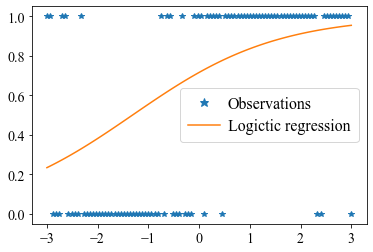

In [63]:
b = B[likelihood_sums.index(max(likelihood_sums))]
gkr = GKR(X, Y, b)

weight = [gkr.predict(x) for x in X]

logreg = LogisticRegression(penalty='none')
logreg.fit(X.reshape(-1, 1), Y,sample_weight=weight)
p_pred_global = logreg.predict_proba(X.reshape(-1, 1))[:, 1]
plt.plot(X, Y, '*', label='Observations')
plt.plot(X, p_pred_global, label='Logictic regression')
plt.legend()
plt.show()

__4.3__

In [64]:
def cross_validation_regression(sample, target, h):
    n = sample.shape[0]
    mask = np.ones(n, dtype=np.bool_)
    bw = np.r_[h]
    summ = 0
    for i in range(n):
        mask[i] = False
        nw = KernelReg(target[mask], sample[mask], var_type="c", reg_type="lc", bw=bw)
        mask[i] = True
        summ += (target[i] - nw.fit(sample[i].reshape(1, 1))[0])**2
    return summ.item()

In [65]:
h_list = B
cv_hist = np.array([cross_validation_regression(X, Y, hi) for hi in h_list])

In [66]:
print('Optimal bandwidth: ', h_list[np.argmin(cv_hist)])

Optimal bandwidth:  0.48


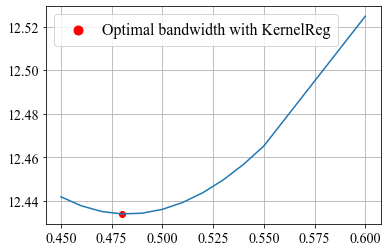

In [67]:
plt.plot(h_list, cv_hist)
plt.scatter(h_list[np.argmin(cv_hist)], cv_hist[np.argmin(cv_hist)], c = 'r', label = 'Optimal bandwidth with KernelReg')
plt.grid(True)
plt.legend()

__Conclusion:__ As it can be seen optimal bandwidths are similar to each other. The one obtained with LogReg is equal to 0.46, another one (using local linear kernel regression method) is equal 0.48.